# Examples and Exercises from Think Stats, 2nd Edition - Chapter 5: Modeling Distributions

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


Distributions we have used so far are called **empirical distributions** because they are based on empricial observations, which are finite samples.

The alternative is an **analytic distribution**, which is caracterized by a CDF that is a mathematical function. Analytic distributions can be used to model empirical distributions. In this context, a **model** is a simplification that leaves out unneeded details. This chapter presents common analytic distributions and uses them to model data from a variety of sources. See `analytic.py` for the source code in this chapter.

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import nsfg
import first
import analytic

import thinkstats2
import thinkplot

## Exponential distribution

Let's start with an **exponential distribution** since it's relatively simple. The CDF of a the exponential distribution is:

$$CDF(x) = 1 - e^{-\lambda x}$$

The parameter, $\lambda$, determines the shape of the distribution. See below figure for $\lambda$ value of 2.0, 1, and 0.5.

Here's what the exponential CDF looks like with those range of parameters.

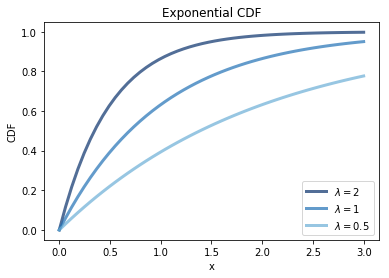

In [2]:
thinkplot.PrePlot(3)
for lam in [2.0, 1, 0.5]:
    xs, ps = thinkstats2.RenderExpoCdf(lam, 0, 3.0, 50)
    label = r'$\lambda=%g$' % lam
    thinkplot.Plot(xs, ps, label=label)
    
thinkplot.Config(title='Exponential CDF', xlabel='x', ylabel='CDF', 
                 loc='lower right')

In the real world, exponential distributions come up when we look at a series of events and measure the times in between events, called **interarrival times**. If the events are equally likely to occur at any time, the distribution of interarrival times tends to look like an exponential distribution. How does this work?

If you plot the complementary CDF (CCDF) of a dataset that you think is exponential, you expect to see a function like:

$$y \approx e^{-\lambda x}$$

Taking the log of both sides yields:

$$\log y \approx -\lambda x$$

Here's the distribution of interarrival times from a dataset of birth times.

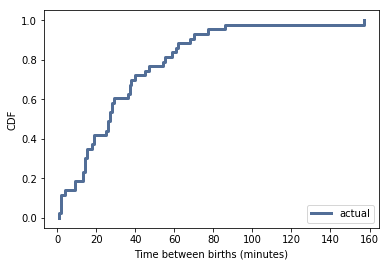

In [3]:
df = analytic.ReadBabyBoom()
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label='actual')

thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Time between births (minutes)', ylabel='CDF')

It seems to have a general shape of an examplonential distribution, but how can we tell? 

One way is to plot the **complementary CDF**, which is 1 - CDF($x$), on a log-y scale. For data from an exponential distribution, the result is a straight line

Here's what the CCDF looks like on a log-y scale.  A straight line is consistent with an exponential distribution.

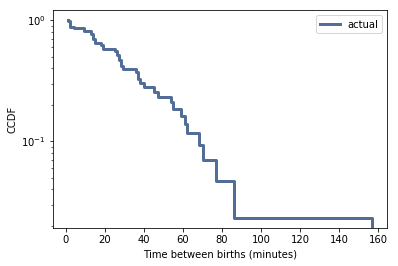

In [4]:
thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel='Time between births (minutes)',
                 ylabel='CCDF', yscale='log', loc='upper right')

It is not exactly straight, which indicates that the exponential distrubtion is not a perfect model for this data. Most likely the underlying assumption -- that a birth is equally likely at any time of the day -- is not exactly true. Nevertheless, it might be reasonable to model this dataset with an exponential distribution. With that simplification, we can summarize the distribution with a single parameter, $\theta$.

$\lambda$ can be interpreted as a rate; that is, the number of events that occur, on average, in a unit of time. In this example, 44 babies are born in 24 hrs, so the rate is $\lambda = 0.0306$ per minute. The mean of an exponential distribution is $ 1 / \lambda$, so the mean time between births mean time between births is 32.7 minutes.

## Normal distribution

The **normal distribution**, also called Gaussian, is commonly used because it describes many phenomena, at least approximately. It turns out that there is a good for its ubiquity, which we will get into in "Central Limit Theorem" on page 186.

The normal distribution is characterized by two parameters: the mean, $\mu$ (also referred to as the "expected value"), and the standard deviation, $\sigma$. The normal distrubtion with $\mu$ = 0 and $\sigma$ = 1 is called the [**standard normal distribution**](https://en.wikipedia.org/wiki/Standard_deviation#/media/File:Standard_deviation_diagram.svg). Its CDF is defined by an integral that does not have a closed form solution, but there are algoirhtms that evaluate it efficiently. One of them is provided by SciPy: scipy.stats.norm is an object that represents a normal distribution; it provides a method, `cdf`, that evaluates the standard normal CDF. 

```python
import scipy.stats
scipy.stats.norm.cdf(0) #Result is 0.5
```

The result is correct: the median of the standard normal distribution is 0 (the same as the mean), and half of the values fall below the median, so CDF(0) = 0.5.

`norm.cdf` takes the optional paramters: `loc`, which specieis the mean, and `scale`, which specifies the standard deviation. `thinkstats2` makes this function a little easier (clearer) to use by providing the `EvalNormalCdf`, which takes parameters `mu` and `sigma` and evaluates the CDF at `x`.

```python
def EvalNormalCdf(x, mu=0, signma=1):
    return scipy.stats.norm.cdf(x, loc=mu, scale=sigma)
```



Here's what the normal CDF looks like with a range of parameters.

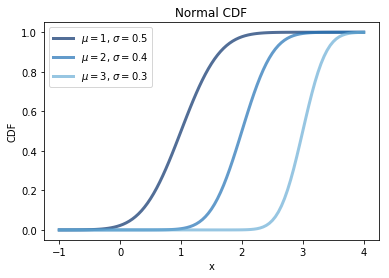

In [5]:
thinkplot.PrePlot(3)

mus = [1.0, 2.0, 3.0]
sigmas = [0.5, 0.4, 0.3]
for mu, sigma in zip(mus, sigmas):
    xs, ps = thinkstats2.RenderNormalCdf(mu=mu, sigma=sigma, 
                                               low=-1.0, high=4.0)
    label = r'$\mu=%g$, $\sigma=%g$' % (mu, sigma)
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title='Normal CDF', xlabel='x', ylabel='CDF',
                 loc='upper left')

I'll use a normal model to fit the distribution of birth weights from the NSFG.

In [6]:
preg = nsfg.ReadFemPreg()
weights = preg.totalwgt_lb.dropna()

Here's the observed CDF and the model.  The model fits the data well except in the left tail.

Mean, Var 7.280883100022579 1.5452125703544897
Sigma 1.2430657948614343


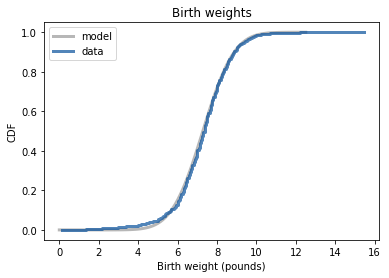

In [7]:
# estimate parameters: trimming outliers yields a better fit
mu, var = thinkstats2.TrimmedMeanVar(weights, p=0.01) #No explanation of thios method in the text..
print('Mean, Var', mu, var)
    
# plot the model
sigma = np.sqrt(var) #StdDev is the squareroot of variance
print('Sigma', sigma)
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=12.5)

thinkplot.Plot(xs, ps, label='model', color='0.6')

# plot the data
cdf = thinkstats2.Cdf(weights, label='data')

thinkplot.PrePlot(1)
thinkplot.Cdf(cdf) 
thinkplot.Config(title='Birth weights',
                 xlabel='Birth weight (pounds)',
                 ylabel='CDF')

Below the 10th percentile there is a discrepancy between the data and the model; there are more light babies than we would expect in a normal distribution. If we are specifically interested in preterm babies, it would be important to get this part of the distribution right so it might not be appropriate to use the normal model.

# Normal Probability Plot

For the exponential distribution, and a few others, there a simple transformations we can use to test whether an analytic distribution is a good model for a dataset.  For the normal distribution there is no such transformation, but there is an alternative called a **normal proability plot** (also known as "normal plot"). There are two ways to generate a normal probability plot: [the hard way](https://en.wikipedia.org/wiki/Normal_probability_plot) and the easy way. Here's the easy way:

1. Sort the values in the sample. 
2. From a standard normal distribution ($\mu$ = 0 and $\sigma$ = 1), generate a random sample with the same size as the sample, and sort it.
3. Plot the sorted values from the sample versus the random samples.

If the distribution of the sample is approximately normal, the result is a straight line with the intercept `mu` and slope `sigma`. `thinkstats` provides `NormalProbability`, which takes a sample and returns two NumPy arrays:

```python
xs, ys = thinkstats2.NormalProbability(sample)
```

`ys` contains the sorted values from `sample`; `xs` contains the random values from the standard normal distribution.

A normal probability plot is a visual test for normality.  The following example shows that if the data are actually from a normal distribution, the plot is approximately straight.

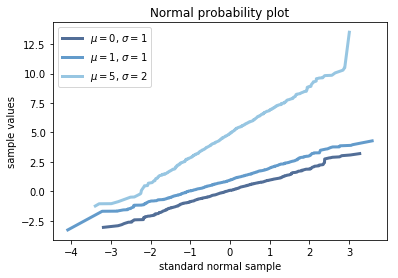

In [8]:
n = 1000
thinkplot.PrePlot(3) 

mus = [0, 1, 5]
sigmas = [1, 1, 2]

for mu, sigma in zip(mus, sigmas):
    sample = np.random.normal(mu, sigma, n)
    xs, ys = thinkstats2.NormalProbability(sample)
    label = '$\mu=%d$, $\sigma=%d$' % (mu, sigma)
    thinkplot.Plot(xs, ys, label=label)

thinkplot.Config(title='Normal probability plot',
                 xlabel='standard normal sample',
                 ylabel='sample values')


Here's the normal probability plot for birth weights, showing that the lightest babies are lighter than we expect from the normal mode, and the heaviest babies are heavier.

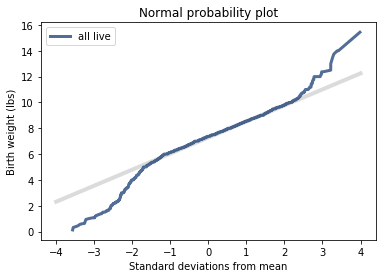

In [9]:
mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
std = np.sqrt(var)

xs = [-4, 4]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

xs, ys = thinkstats2.NormalProbability(weights)
thinkplot.Plot(xs, ys, label='all live')

thinkplot.Config(title='Normal probability plot',
                 xlabel='Standard deviations from mean',
                 ylabel='Birth weight (lbs)')

`weights` is a pandas Series of birth weights; `mean` and `std` are the mean and standard deviation.

`FitLine` takes a sequence of `xs`, an intercept, and a slope; it returns `fxs` and `fys` that represent a line with the given parameters, evaluated at the values in `xs`.

`NormalProbability` returns `xs` and `ys` that contain values from the standard normal distribution and values from `weights`. If the distribution of weights is normal, the data should match the model.

If we suspect that the deviation in the left tail is due to preterm babies, we can check by selecting only full term births.

In [10]:
full_term = preg[preg.prglngth >= 37]
term_weights = full_term.totalwgt_lb.dropna()

Now the deviation in the left tail is almost gone (below), but the heaviest babies are still heavy. This plot suggests that the normal model describes the distribution well within a few standard deviations from the mean, but not in the tails. Whether it is good enough for practical purposes depends on the purposes.

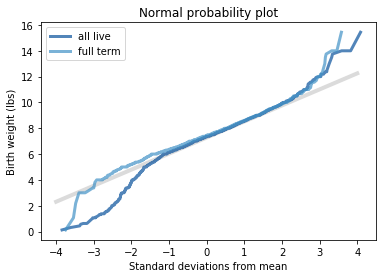

In [11]:
mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
std = np.sqrt(var)

xs = [-4, 4]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

thinkplot.PrePlot(2) 
xs, ys = thinkstats2.NormalProbability(weights)
thinkplot.Plot(xs, ys, label='all live')

xs, ys = thinkstats2.NormalProbability(term_weights)
thinkplot.Plot(xs, ys, label='full term')
thinkplot.Config(title='Normal probability plot',
                 xlabel='Standard deviations from mean',
                 ylabel='Birth weight (lbs)')

## Lognormal model

If the logarithms of a set of values have a normal distribution, the values have a log-normal distribution. The CDF of the lognormal distribution is the same as the CDF of the normal distribtuion, with log($x$) substituted for ($X$). The parameters of the lognormal distribution are usually denoted as $\mu$ and $\sigma$, but they are *not* the mean and standard deviation. The mean of alog-normal distribution is exp($\mu + \sigma^2 / 2$) and the standard deviation is [ugly](https://en.wikipedia.org/wiki/Log-normal_distribution) (See "Properties - Arithmetic moments").

If a sample is approximately lognormal and you plot its CDF on a log-x scale, it will have the characterisitc (sigmoidal) shape of a normal distribution (and a straight line in a normal probability plot).

As an example of a lognormal disrtribution, we'll look at adult weights from the BRFSS.

In [12]:
import brfss
df = brfss.ReadBrfss()
weights = df.wtkg2.dropna()

The following function estimates the parameters of a normal distribution and plots the data and a normal model.

In [13]:
def MakeNormalModel(weights):
    """Plots a CDF with a Normal model.

    weights: sequence
    """
    cdf = thinkstats2.Cdf(weights, label='weights')

    mean, var = thinkstats2.TrimmedMeanVar(weights)
    std = np.sqrt(var)
    print('n, mean, std', len(weights), mean, std)

    xmin = mean - 4 * std
    xmax = mean + 4 * std

    xs, ps = thinkstats2.RenderNormalCdf(mean, std, xmin, xmax)
    thinkplot.Plot(xs, ps, label='model', linewidth=4, color='0.8')
    thinkplot.Cdf(cdf)

Here's the distribution of adult weights and a normal model, which is not a very good fit.

n, mean, std 398484 78.59599565702814 17.754555191798705


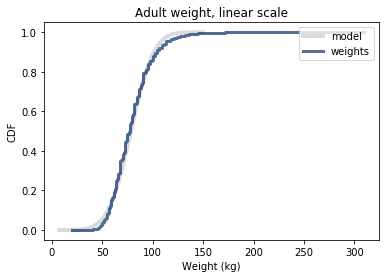

In [14]:
MakeNormalModel(weights)
thinkplot.Config(title='Adult weight, linear scale', xlabel='Weight (kg)',
                 ylabel='CDF', loc='upper right')

Here's the distribution of adult weight and a lognormal model, plotted on a log-x scale.  The model is a better fit for the data, although the heaviest people are heavier than the model expects.

n, mean, std 398484 1.884660713731975 0.0962358025915134


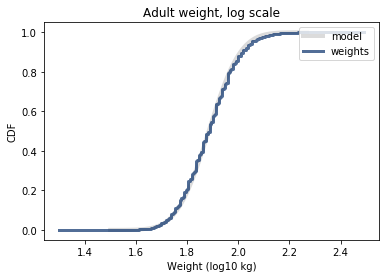

In [15]:
log_weights = np.log10(weights)
MakeNormalModel(log_weights)
thinkplot.Config(title='Adult weight, log scale', xlabel='Weight (log10 kg)',
                 ylabel='CDF', loc='upper right')

The following function generates a normal probability plot.

In [16]:
def MakeNormalPlot(weights):
    """Generates a normal probability plot of birth weights.

    weights: sequence
    """
    mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
    std = np.sqrt(var)

    xs = [-5, 5]
    xs, ys = thinkstats2.FitLine(xs, mean, std)
    thinkplot.Plot(xs, ys, color='0.8', label='model')

    xs, ys = thinkstats2.NormalProbability(weights)
    thinkplot.Plot(xs, ys, label='weights')

When we generate a normal probability plot with adult weights, we can see clearly that the data deviate from the model systematically.

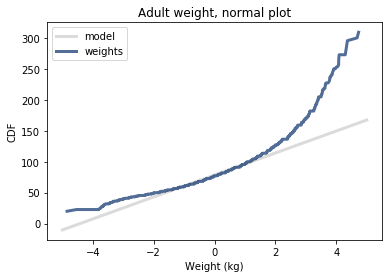

In [17]:
MakeNormalPlot(weights)
thinkplot.Config(title='Adult weight, normal plot', xlabel='Weight (kg)',
                 ylabel='CDF', loc='upper left')

If we make a normal probability plot with log weights, the model fit the data well except in the tails, where the heaviest people exceed expectations.

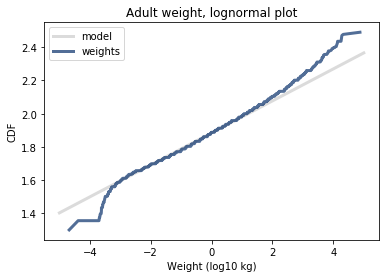

In [18]:
MakeNormalPlot(log_weights)
thinkplot.Config(title='Adult weight, lognormal plot', xlabel='Weight (log10 kg)',
                 ylabel='CDF', loc='upper left')

## Pareto distribution

The **Pareto Distribution** is named after the economist Vilfredo Pareto, who used it to describe the distribution of wealth. Since then, it has been used to describe phenomena in the natural and social sciences including sizes of cities and towns, sand particles and meteroites, and forest fires and earthquakes. 

The CDF opf the Pareto distribution is:  
$$CDF(X) = 1 - \bigg( \frac{x}{x_m} \bigg) ^{-\alpha}$$

$x_m$ and $\alpha$ determine the location and shape of the distribution.  $x_m$ is the minimum possible value. 

Here's what the Pareto CDF looks like with a range of parameters.

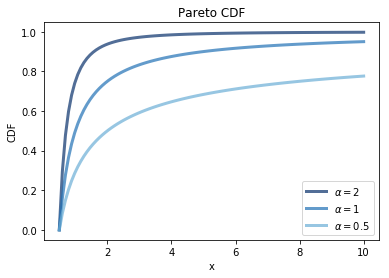

In [19]:
xmin = 0.5

thinkplot.PrePlot(3)
for alpha in [2.0, 1.0, 0.5]:
    xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100) 
    thinkplot.Plot(xs, ps, label=r'$\alpha=%g$' % alpha)
    
thinkplot.Config(title='Pareto CDF', xlabel='x',
                 ylabel='CDF', loc='lower right')

There's a simple visual test that indicates whether an emperical distribution fits a Pareto distribution. On a log-log scale, the CCDF looks like a straight line. This is why:  

If you plot the complementary CDF (CCDF) of a sample from a Pareto distribution on a linear scale, you'd expect to see a function like:  
  
$$y \approx \bigg( \frac{x}{x_m} \bigg) ^{-\alpha}$$

Taking the log of both sides yields:  
  
$$\log y \approx -\alpha(\log x - \log x_m)$$

So if you plot log $y$ versus log $x$, it should look like a straight line with a slope $-\alpha$ and intercept of $\alpha \log x$.

The distribution of populations for cities and towns is sometimes said to be Pareto-like.

In [20]:
import populations

pops = populations.ReadData()
print('Number of cities/towns', len(pops))

Number of cities/towns 19515


Here's the distribution of population for cities and towns in the U.S., along with a Pareto model.  The model fits the data well in the tail.

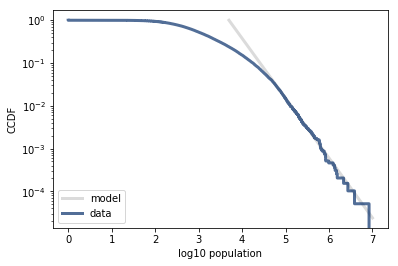

In [21]:
log_pops = np.log10(pops)
cdf = thinkstats2.Cdf(pops, label='data')
cdf_log = thinkstats2.Cdf(log_pops, label='data')

# pareto plot
xs, ys = thinkstats2.RenderParetoCdf(xmin=5000, alpha=1.4, low=0, high=1e7)
thinkplot.Plot(np.log10(xs), 1-ys, label='model', color='0.8')

thinkplot.Cdf(cdf_log, complement=True) 
thinkplot.Config(xlabel='log10 population',
                 ylabel='CCDF',
                 yscale='log', loc='lower left')

The lognormal model might be a better fit for this data (as is often the case for things that are supposed to be Pareto).

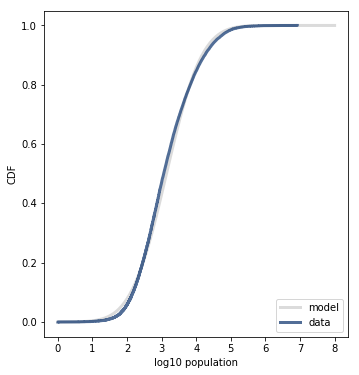

In [22]:
thinkplot.PrePlot(cols=2)

mu, sigma = log_pops.mean(), log_pops.std()
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=8)
thinkplot.Plot(xs, ps, label='model', color='0.8')

thinkplot.Cdf(cdf_log) 
thinkplot.Config(xlabel='log10 population',
                 ylabel='CDF', loc='lower right')

Here's a normal probability plot for the log-populations.  The model fits the data well except in the right tail, where the biggest cities are bigger than expected.

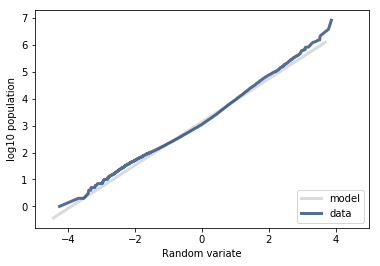

In [23]:
thinkstats2.NormalProbabilityPlot(log_pops, label='data')
thinkplot.Config(xlabel='Random variate',
                 ylabel='log10 population',
                 xlim=[-5, 5])

## Random variates

When we have an analytic CDF, we can sometimes invert it to generate random values.  The following function generates values from an exponential distribution.

In [24]:
import random

def expovariate(lam):
    p = random.random()
    x = -np.log(1-p) / lam
    return x

We can test it by generating a sample.

In [25]:
t = [expovariate(lam=2) for _ in range(1000)]

And plotting the CCDF on a log-y scale.

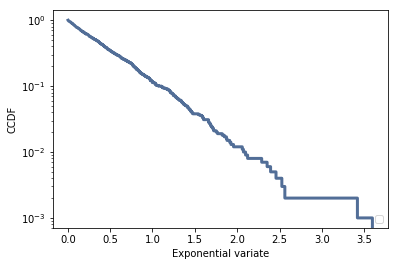

In [26]:
cdf = thinkstats2.Cdf(t)

thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel='Exponential variate', ylabel='CCDF', yscale='log')

A straight line is consistent with an exponential distribution.

As an exercise, write a function that generates a Pareto variate.

## Exercises

**Exercise:** In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

`scipy.stats` contains objects that represent analytic distributions

In [2]:
import scipy.stats

For example <tt>scipy.stats.norm</tt> represents a normal distribution.

In [3]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

A "frozen random variable" can compute its mean and standard deviation.

In [4]:
dist.mean(), dist.std()

(178.0, 7.7)

It can also evaluate its CDF.  How many people are more than one standard deviation below the mean?  About 16%

In [5]:
dist.cdf(mu-sigma)

0.1586552539314574

How many people are between 5'10" and 6'1"?

In [6]:
#1. Convert inches to cm
inches = 2.54 
minHeight = 5 * 12 * 2.54 + 10 * 2.54
maxHeight = 6 * 12 * 2.54 + 1 * 2.54

belowMax = dist.cdf(maxHeight)
belowMin = dist.cdf(minHeight)
percentInRange = belowMax - belowMin
print(belowMax,belowMin,percentInRange)

# ~ 34.3% of men are in this height range

(0.8323858654963063, 0.48963902786483265, 0.3427468376314737)


**Exercise:** To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [7]:
alpha = 1.7
xmin = 1       # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()
max(dist.rvs(size=1000))

39.37091375477843

What is the mean height in Pareto world?

In [8]:
import thinkplot, thinkstats2

cdf = thinkstats2.Cdf(dist.rvs(size=1000), label='height')
thinkplot.Cdf(cdf, complement=False)
thinkplot.Config(title='Pareto CDF', xlabel='x',
                ylabel='CDF', loc='lower right',
                xlim=[0, 10])


What fraction of people are shorter than the mean?

In [9]:
dist.cdf(dist.mean())

0.778739697565288

Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

In [10]:
population = 7000000000
dist.sf(1000)*population
(1-dist.cdf(1000))*population 

55602.976430479954

How tall do we expect the tallest person to be?

In [25]:
height = 610000 #Start here
tallerPeople = True
"""while tallerPeople:
    height += 1
    numPeopleAtThisHeight = dist.sf(height)
    if not numPeopleAtThisHeight > 1:
        tallerPeople = False
        print("Tallest person expected to be {}".format()
"""
numPeopleAtThisHeight = dist.sf(height) * 7e9
print(numPeopleAtThisHeight)

1.0233809313278974


**Exercise:** The Weibull distribution is a generalization of the exponential distribution that comes up in failure analysis (see http://wikipedia.org/wiki/Weibull_distribution). Its CDF is

$\mathrm{CDF}(x) = 1 − \exp[−(x / λ)^k]$ 

Can you find a transformation that makes a Weibull distribution look like a straight line? What do the slope and intercept of the line indicate?

Use `random.weibullvariate` to generate a sample from a Weibull distribution and use it to test your transformation.

Generate a sample from a Weibull distribution and plot it using a transform that makes a Weibull distribution look like a straight line.

`thinkplot.Cdf` provides a transform that makes the CDF of a Weibull distribution look like a straight line.

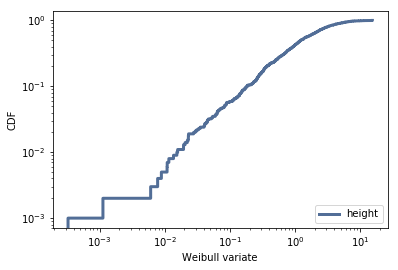

In [71]:
import random, math
import numpy as np

#sample = [np.log(-np.log(1-(random.weibullvariate(2, 1)))) for _ in range(1000)]
#sample = [value for value in sample if not math.isnan(value)]
#print(sample[:10])
sample = [random.weibullvariate(2, 1) for _ in range(1000)]
cdf = thinkstats2.Cdf(sample, label='height')
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Weibull variate', ylabel='CDF',yscale='log',xscale='log')


If it's on a log-log scale as with the Pareto distribution, perhaps it's slope would be $-\alpha$ and it's intercept $\alpha\log x_m$. No further detail in solution, so hard to say if this is right.

Axes of Weibull plot are:  $\ln \big( - \ln \big( 1 - \hat{F}(x) \big) \big) $ and $\ln \big(x \big)$

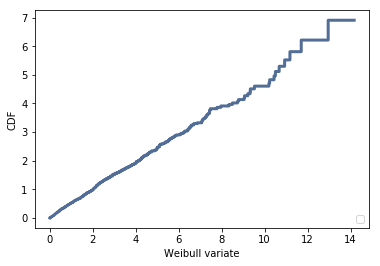

In [72]:
sample = [random.weibullvariate(2, 1) for _ in range(1000)]
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf, transform='weibull')
thinkplot.Config(xlabel='Weibull variate', ylabel='CDF')

**Exercise:** For small values of `n`, we don’t expect an empirical distribution to fit an analytic distribution exactly. One way to evaluate the quality of fit is to generate a sample from an analytic distribution and see how well it matches the data.

For example, in Section 5.1 we plotted the distribution of time between births and saw that it is approximately exponential. But the distribution is based on only 44 data points. To see whether the data might have come from an exponential distribution, generate 44 values from an exponential distribution with the same mean as the data, about 33 minutes between births.

Plot the distribution of the random values and compare it to the actual distribution. You can use random.expovariate to generate the values.

In [129]:
import analytic

df = analytic.ReadBabyBoom()
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label='actual')

n = len(diffs)
lam = 44.0 / 24 / 60
sample = [random.expovariate(lam) for _ in range(n)]

1/lam, np.mean(sample)

(32.72727272727273, 32.79903901118392)

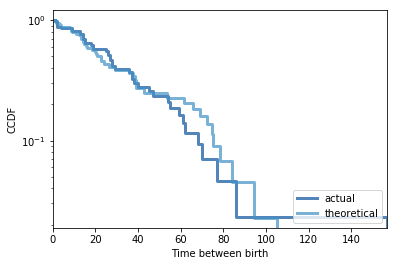

In [130]:
#Analytic distribution
analytic_cdf = thinkstats2.Cdf(sample, label='theoretical')
thinkplot.PrePlot(2)
thinkplot.Cdfs([cdf, analytic_cdf], complement=True)
#thinkplot.Plot(cdf, label = 'actual')
#thinkplot.Plot(analytic_cdf, label = 'theoretical')
thinkplot.Config(xlabel='Time between birth', 
                 ylabel='CCDF',yscale='log',
                xlim=[0, max(diffs[1:])])



### Exercise 5-5


/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')


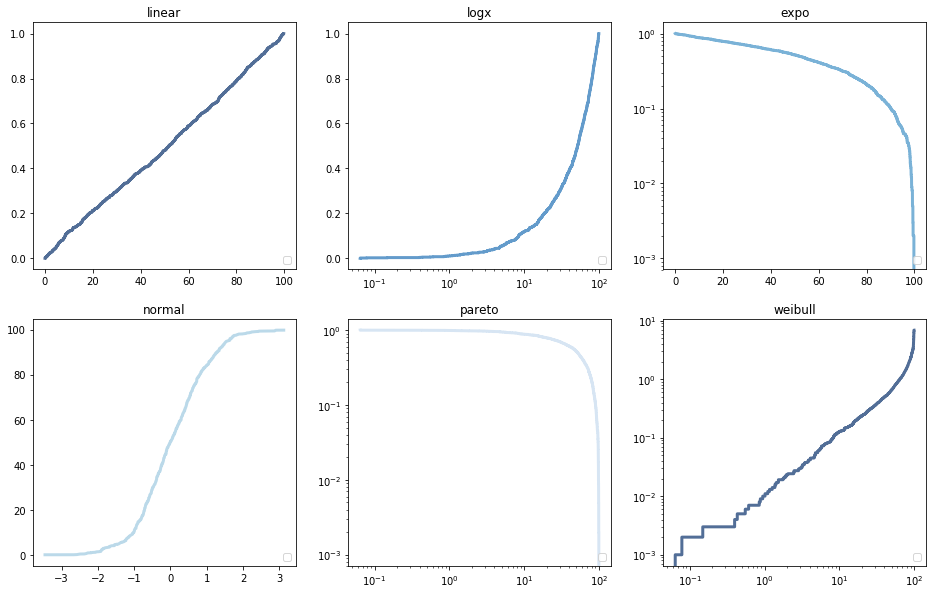

In [133]:
filename = "mystery0.dat"

def ReadFile(filename):
    """Reads a list of numbers from a file.

    filename: string

    returns: list of float
    """
    fp = open(filename)
    data = []
    for line in fp:
        x = float(line.strip())
        data.append(x)
    return data

data = ReadFile(filename)
cdf = thinkstats2.Cdf(data)

thinkplot.PrePlot(rows=2, cols=3)
thinkplot.SubPlot(1)
thinkplot.Cdf(cdf)
thinkplot.Config(title='linear')

thinkplot.SubPlot(2)
scale = thinkplot.Cdf(cdf, xscale='log')
thinkplot.Config(title='logx', **scale)

thinkplot.SubPlot(3)
scale = thinkplot.Cdf(cdf, transform='exponential')
thinkplot.Config(title='expo', **scale)

thinkplot.SubPlot(4)
xs, ys = thinkstats2.NormalProbability(data)
thinkplot.Plot(xs, ys)
thinkplot.Config(title='normal')

thinkplot.SubPlot(5)
scale = thinkplot.Cdf(cdf, transform='pareto')
thinkplot.Config(title='pareto', **scale)

thinkplot.SubPlot(6)
scale = thinkplot.Cdf(cdf, transform='weibull')
thinkplot.Config(title='weibull', **scale)

**Worked Example:** The distributions of wealth and income are sometimes modeled using lognormal and Pareto distributions. To see which is better, let’s look at some data.

The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc.py`, which reads this file.

Extract the distribution of incomes from this dataset. Are any of the analytic distributions in this chapter a good model of the data?

In [135]:
import hinc
df = hinc.ReadData()
df

,income,freq,cumsum,ps
0,4.999000e+03,4204,4204,0.034330
1,9.999000e+03,4729,8933,0.072947
2,1.499900e+04,6982,15915,0.129963
3,1.999900e+04,7157,23072,0.188407
4,2.499900e+04,7131,30203,0.246640
5,2.999900e+04,6740,36943,0.301679
6,3.499900e+04,6354,43297,0.353566
7,3.999900e+04,5832,49129,0.401191
8,4.499900e+04,5547,54676,0.446488
9,4.999900e+04,5254,59930,0.489392


Here's what the CDF looks like on a linear scale.

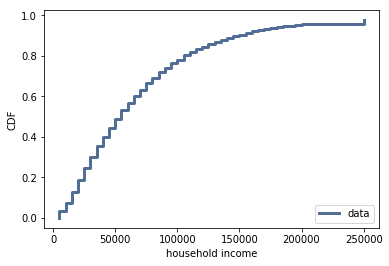

In [137]:
xs, ps = df.income.values, df.ps.values #percentile score values?
cdf = thinkstats2.Cdf(xs, ps, label='data')
cdf_log = thinkstats2.Cdf(np.log10(xs), ps, label='data')
    
# linear plot
thinkplot.Cdf(cdf) 
thinkplot.Config(xlabel='household income',
                   ylabel='CDF')


To check whether a Pareto model describes the data well, I plot the CCDF on a log-log scale.

I found parameters for the Pareto model that match the tail of the distribution.

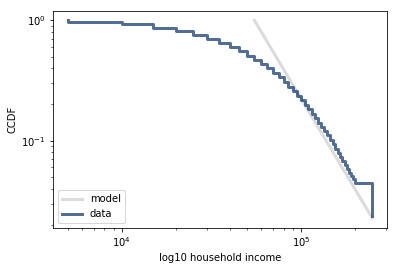

In [138]:
xs, ys = thinkstats2.RenderParetoCdf(xmin=55000, alpha=2.5, 
                                     low=0, high=250000)

thinkplot.Plot(xs, 1-ys, label='model', color='0.8')

thinkplot.Cdf(cdf, complement=True) 
thinkplot.Config(xlabel='log10 household income',
                 ylabel='CCDF',
                 xscale='log',
                 yscale='log', 
                 loc='lower left')

For the lognormal model I estimate mu and sigma using percentile-based statistics (median and IQR).

In [45]:
median = cdf_log.Percentile(50)
iqr = cdf_log.Percentile(75) - cdf_log.Percentile(25)
std = iqr / 1.349 #Not sure where this 1.349 numnber is coming from

# choose std to match the upper tail
std = 0.35
print(median, std)

4.74035479316 0.35


Here's what the distribution, and fitted model, look like on a log-x scale.

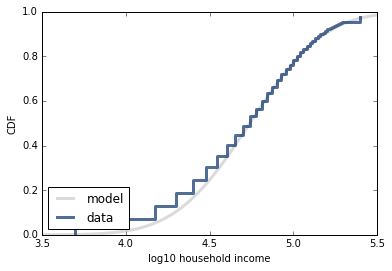

In [46]:
xs, ps = thinkstats2.RenderNormalCdf(median, std, low=3.5, high=5.5)
thinkplot.Plot(xs, ps, label='model', color='0.8')

thinkplot.Cdf(cdf_log) 
thinkplot.Config(xlabel='log10 household income',
                 ylabel='CDF')

My conclusions based on these figures are:

1) The Pareto model might be a reasonable choice for the top
   10-20% of incomes.

2) The lognormal model captures the shape of the distribution better,
   with some deviation in the left tail.  With different
   choices for sigma, you could match the upper or lower tail, but not
   both at the same time.
 
In summary I would say that neither model captures the whole distribution,
so you might have to 

1) look for another analytic model, 

2) choose one that captures the part of the distribution that is most 
   relevent, or 

3) avoid using an analytic model altogether.